<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/verao_covid_obitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import requests
import io
import gzip
import pandas as pd
import seaborn as sns; sns.set_theme(style="whitegrid")

In [65]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, parse_dates=["date"], dtype={"city_ibge_code": str})

In [66]:
cols = "MUNICIPIO","COD_IBGE","CLUSTER","UF","ARRECADACAO","QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL"
cidades_turisticas = pd.read_excel('https://github.com/mirianbatista/covid-fatores/blob/master/RELATORIO_CATEGORIZACAO_2019-Portal.xls?raw=true', usecols=cols, dtype={"COD_IBGE": str})
cidades = cidades_turisticas.MUNICIPIO.to_list()

In [67]:
cidades_turisticas[cidades_turisticas.isna().any(axis=1)]

,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER


In [68]:
covid_cidades_turisticas = covid.loc[covid['city'].isin(cidades)]
covid_cidades_turisticas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1193249 entries, 0 to 2359790
Data columns (total 18 columns):
 #   Column                                         Non-Null Count    Dtype         
---  ------                                         --------------    -----         
 0   city                                           1193249 non-null  object        
 1   city_ibge_code                                 1193249 non-null  object        
 2   date                                           1193249 non-null  datetime64[ns]
 3   epidemiological_week                           1193249 non-null  int64         
 4   estimated_population                           1193249 non-null  float64       
 5   estimated_population_2019                      1193249 non-null  float64       
 6   is_last                                        1193249 non-null  bool          
 7   is_repeated                                    1193249 non-null  bool          
 8   last_available_confirmed        

In [69]:
covid_cidades_turisticas.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [70]:
covid_tur = pd.merge(covid_cidades_turisticas, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left").dropna(subset=['CLUSTER'])
covid_tur = covid_tur[covid_tur.estimated_population >= 20000]

In [71]:
def aumento_percentual(t0, t1):
  return (t1-t0)/t0 if t0 != 0 else 0

def calcula_aumento_relativo(df, x_col, date_col, from_date, to_date):
    from_x = int(df[df[date_col] == from_date][x_col])
    to_x = int(df[df[date_col] == to_date][x_col])
    abs_dif = to_x - from_x
    relative_dif = aumento_percentual(from_x, to_x)
    return {f'{x_col}_from': from_x, f'{x_col}_to': to_x, 'dif': abs_dif,'relative_dif': relative_dif}

In [72]:
covid_tur_aumento_verao = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2020-12-17', to_date='2021-03-16').to_frame()
covid_tur_aumento_verao.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento_verao = covid_tur_aumento_verao['explodir'].apply(pd.Series)
covid_tur_aumento_verao.reset_index(inplace=True)
covid_tur_aumento_verao.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
866,4106506,20580.0,2.0,39.0,37.0,18.500000
395,2923605,21695.0,1.0,12.0,11.0,11.000000
825,3551603,29452.0,3.0,22.0,19.0,6.333333
555,3171006,20642.0,5.0,32.0,27.0,5.400000
1018,4313201,21536.0,4.0,25.0,21.0,5.250000
...,...,...,...,...,...,...
242,2601607,20730.0,0.0,5.0,5.0,0.000000
210,2414407,33503.0,24.0,24.0,0.0,0.000000
107,2103174,21840.0,7.0,7.0,0.0,0.000000
118,2108306,38731.0,9.0,9.0,0.0,0.000000


In [129]:
covid_tur_aumento_categorias_verao = pd.merge(covid_tur_aumento_verao, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias_verao.sort_values(by="relative_dif")

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
103,2102705,22117.0,4.0,3.0,-1.0,-0.250000,MA,Cantanhede,2102705,0,0,D
118,2108306,38731.0,9.0,9.0,0.0,0.000000,MA,Penalva,2108306,1834,0,D
372,2914406,25478.0,0.0,8.0,8.0,0.000000,BA,Iraquara,2914406,0,0,D
437,3108602,32405.0,5.0,5.0,0.0,0.000000,MG,Brasília de Minas,3108602,0,0,D
210,2414407,33503.0,24.0,24.0,0.0,0.000000,RN,Touros,2414407,31930,0,C
...,...,...,...,...,...,...,...,...,...,...,...,...
1018,4313201,21536.0,4.0,25.0,21.0,5.250000,RS,Nova Petrópolis,4313201,46896,1264152,C
555,3171006,20642.0,5.0,32.0,27.0,5.400000,MG,Vazante,3171006,36222,0,D
825,3551603,29452.0,3.0,22.0,19.0,6.333333,SP,Serra Negra,3551603,167317,9423924,B
395,2923605,21695.0,1.0,12.0,11.0,11.000000,BA,Paramirim,2923605,0,0,D


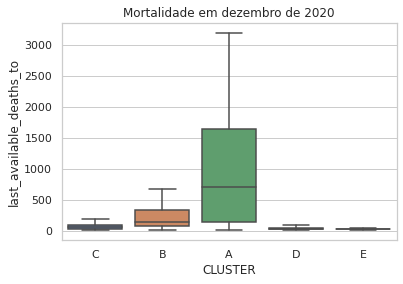

In [74]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias_verao, showfliers = False).set_title("Mortalidade em dezembro de 2020")

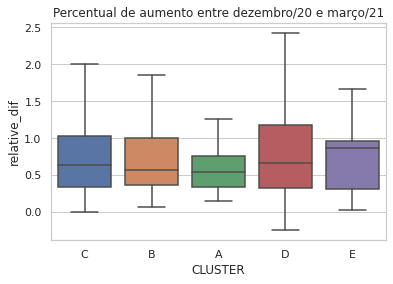

In [75]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias_verao, showfliers = False).set_title("Percentual de aumento entre dezembro/20 e março/21")

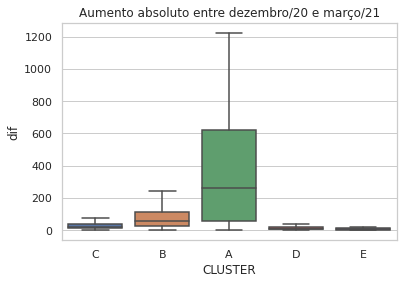

In [76]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias_verao, showfliers = False).set_title("Aumento absoluto entre dezembro/20 e março/21")

In [77]:
categorias_verao = pd.concat([covid_tur_aumento_categorias_verao.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias_verao.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [78]:
categorias_verao.reset_index(inplace=True)
categorias_verao

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,1287.881356,455.0,1865.508475,705.0,577.627119,262.0,0.592370,0.536103,0.469390
1,B,238,183898.054622,123057.0,159.529412,85.0,250.113445,143.0,90.584034,58.0,0.782802,0.572646,0.692379
2,C,397,74728.382872,51338.0,58.221662,32.0,91.327456,52.0,33.105793,20.0,0.821278,0.634146,0.709165
3,D,450,39418.280000,30428.5,25.397778,16.0,39.795556,28.0,14.397778,10.0,0.933492,0.666667,0.805825
4,E,11,39515.181818,24382.0,20.454545,14.0,35.454545,24.0,15.000000,8.0,0.729664,0.866667,0.870311


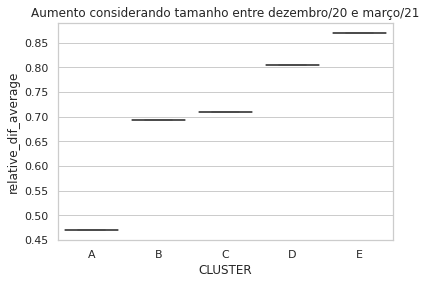

In [79]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias_verao, showfliers = False).set_title("Aumento considerando tamanho entre dezembro/20 e março/21")

**Métricas em ordem decrescente**

In [80]:
mediana_aumento_mortalidade_rel_verao = categorias_verao.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel_verao[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
4,E,0.866667
3,D,0.666667
2,C,0.634146
1,B,0.572646
0,A,0.536103


In [81]:
aumento_considerando_populacao_verao = categorias_verao.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao_verao[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
4,E,0.870311
3,D,0.805825
2,C,0.709165
1,B,0.692379
0,A,0.469390


In [82]:
covid_tur_aumento_categorias_verao.groupby('CLUSTER')['UF'].value_counts().to_frame().unstack()

UF                              ...                                  
UF        AC    AL   AM   AP    BA    CE  ...   RR    RS    SC    SE    SP   TO
CLUSTER                                   ...                                  
A        1.0   2.0  1.0  1.0   4.0   2.0  ...  1.0   2.0   5.0   1.0  11.0  1.0
B        NaN   1.0  NaN  NaN  19.0  12.0  ...  NaN  21.0  15.0   NaN  46.0  2.0
C        2.0   6.0  9.0  2.0  25.0  23.0  ...  NaN  29.0  18.0   6.0  73.0  5.0
D        3.0  16.0  9.0  1.0  30.0  15.0  ...  1.0  41.0  17.0  13.0  67.0  1.0
E        NaN   2.0  NaN  NaN   3.0   1.0  ...  NaN   NaN   1.0   NaN   1.0  NaN

[5 rows x 27 columns]

In [83]:
covid_tur_aumento_categorias_verao.loc[(covid_tur_aumento_categorias_verao['CLUSTER'].eq("E"))].loc[covid_tur_aumento_categorias_verao.UF == "BA"]

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
367,2911808,20700.0,15.0,28.0,13.0,0.866667,BA,Guaratinga,2911808,0,0,E
379,2916500,35883.0,7.0,13.0,6.0,0.857143,BA,Itapicuru,2916500,0,0,E
398,2924603,20098.0,12.0,24.0,12.0,1.000000,BA,Pindobaçu,2924603,0,0,E


In [84]:
covid_tur_aumento_categorias_verao.loc[(covid_tur_aumento_categorias_verao['CLUSTER'].eq("E"))].loc[covid_tur_aumento_categorias_verao.UF == "MG"]

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
471,3129806,182153.0,77.0,158.0,81.0,1.051948,MG,Ibirité,3129806,0,0,E
541,3165537,33413.0,12.0,32.0,20.0,1.666667,MG,Sarzedo,3165537,0,0,E


In [85]:
covid_tur_aumento_categorias_verao.loc[(covid_tur_aumento_categorias_verao['CLUSTER'].eq("E"))].loc[covid_tur_aumento_categorias_verao.UF == "AL"]

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
306,2705705,21738.0,16.0,22.0,6.0,0.375,AL,Olho d'Água das Flores,2705705,0,0,E
316,2708303,23996.0,12.0,15.0,3.0,0.250,AL,São José da Laje,2708303,0,0,E


In [86]:
covid_tur_aumento_categorias_verao.loc[(covid_tur_aumento_categorias_verao['CLUSTER'].eq("D"))].sort_values(by="relative_dif")

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
103,2102705,22117.0,4.0,3.0,-1.0,-0.25,MA,Cantanhede,2102705,0,0,D
95,2100204,22112.0,8.0,8.0,0.0,0.00,MA,Alcântara,2100204,15573,0,D
96,2100907,46771.0,10.0,10.0,0.0,0.00,MA,Araioses,2100907,6010,0,D
313,2707503,20112.0,8.0,8.0,0.0,0.00,AL,Porto Real do Colégio,2707503,3499,0,D
118,2108306,38731.0,9.0,9.0,0.0,0.00,MA,Penalva,2108306,1834,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...
510,3146305,20252.0,3.0,15.0,12.0,4.00,MG,Padre Paraíso,3146305,18287,0,D
771,3535804,20395.0,5.0,29.0,24.0,4.80,SP,Paranapanema,3535804,0,0,D
555,3171006,20642.0,5.0,32.0,27.0,5.40,MG,Vazante,3171006,36222,0,D
395,2923605,21695.0,1.0,12.0,11.0,11.00,BA,Paramirim,2923605,0,0,D


In [87]:
covid_tur_aumento_categorias_verao.loc[(covid_tur_aumento_categorias_verao['CLUSTER'].eq("B"))].sort_values(by="relative_dif")

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
106,2103000,165525.0,112.0,119.0,7.0,0.062500,MA,Caxias,2103000,191422,0,B
147,2303501,72232.0,90.0,96.0,6.0,0.066667,CE,Cascavel,2303501,245835,264334,B
589,3300258,30593.0,9.0,10.0,1.0,0.111111,RJ,Arraial do Cabo,3300258,260542,4168108,B
184,2313401,76537.0,89.0,99.0,10.0,0.112360,CE,Tianguá,2313401,146945,352366,B
347,2903201,156975.0,104.0,116.0,12.0,0.115385,BA,Barreiras,2903201,182508,993389,B
...,...,...,...,...,...,...,...,...,...,...,...,...
986,4304408,45488.0,32.0,109.0,77.0,2.406250,RS,Canela,4304408,147149,5492866,B
431,3105608,138204.0,25.0,92.0,67.0,2.680000,MG,Barbacena,3105608,59071,1076344,B
928,4204202,224013.0,109.0,437.0,328.0,3.009174,SC,Chapecó,4204202,234259,6771846,B
1034,4316808,131365.0,22.0,103.0,81.0,3.681818,RS,Santa Cruz do Sul,4316808,102289,2254033,B


# **Entre 17 de dezembro de 2020 e 16 de janeiro de 2021**

In [88]:
covid_tur_aumento_natal = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2020-12-17', to_date='2021-01-16').to_frame()
covid_tur_aumento_natal.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento_natal = covid_tur_aumento_natal['explodir'].apply(pd.Series)
covid_tur_aumento_natal.reset_index(inplace=True)
covid_tur_aumento_natal.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
395,2923605,21695.0,1.0,6.0,5.0,5.000000
866,4106506,20580.0,2.0,8.0,6.0,3.000000
985,4304200,31421.0,5.0,16.0,11.0,2.200000
527,3154002,23711.0,4.0,12.0,8.0,2.000000
496,3141801,31497.0,2.0,5.0,3.0,1.500000
...,...,...,...,...,...,...
50,1502707,47991.0,28.0,28.0,0.0,0.000000
275,2611507,26175.0,7.0,7.0,0.0,0.000000
802,3546306,34737.0,24.0,23.0,-1.0,-0.041667
210,2414407,33503.0,24.0,23.0,-1.0,-0.041667


In [89]:
covid_tur_aumento_categorias_natal = pd.merge(covid_tur_aumento_natal, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias_natal.sort_values("relative_dif", ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
395,2923605,21695.0,1.0,6.0,5.0,5.000000,BA,Paramirim,2923605,0,0,D
866,4106506,20580.0,2.0,8.0,6.0,3.000000,PR,Coronel Vivida,4106506,4657,0,D
985,4304200,31421.0,5.0,16.0,11.0,2.200000,RS,Candelária,4304200,21204,0,D
527,3154002,23711.0,4.0,12.0,8.0,2.000000,MG,Raul Soares,3154002,20556,0,D
496,3141801,31497.0,2.0,5.0,3.0,1.500000,MG,Minas Novas,3141801,2624,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...
50,1502707,47991.0,28.0,28.0,0.0,0.000000,PA,Conceição do Araguaia,1502707,37250,0,C
275,2611507,26175.0,7.0,7.0,0.0,0.000000,PE,Quipapá,2611507,1906,0,D
802,3546306,34737.0,24.0,23.0,-1.0,-0.041667,SP,Santa Cruz das Palmeiras,3546306,0,0,D
210,2414407,33503.0,24.0,23.0,-1.0,-0.041667,RN,Touros,2414407,31930,0,C


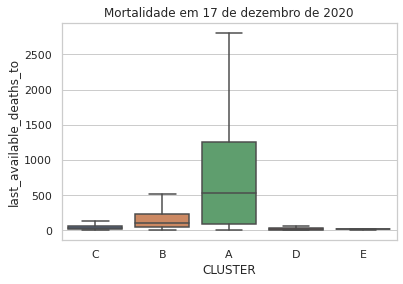

In [90]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias_natal, showfliers = False).set_title("Mortalidade em 17 de dezembro de 2020")

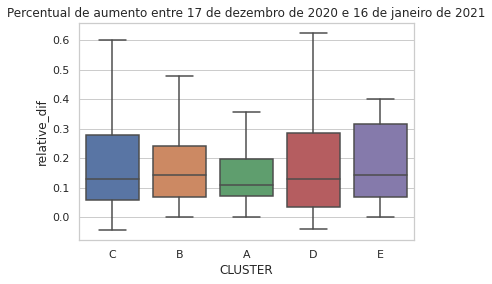

In [91]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias_natal, showfliers = False).set_title("Percentual de aumento entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

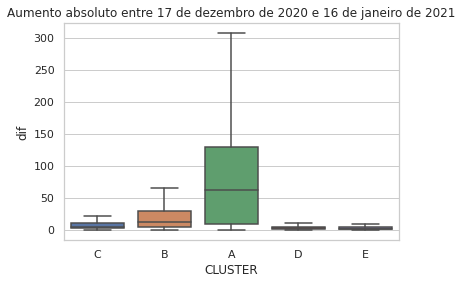

In [92]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias_natal, showfliers = False).set_title("Aumento absoluto entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

In [93]:
categorias_natal = pd.concat([covid_tur_aumento_categorias_natal.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias_natal.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [94]:
categorias_natal.reset_index(inplace=True)
categorias_natal

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,1287.881356,455.0,1430.677966,526.0,142.796610,62.0,0.138729,0.107368,0.113635
1,B,238,183898.054622,123057.0,159.529412,85.0,182.243697,102.0,22.714286,12.0,0.181226,0.142857,0.165877
2,C,397,74728.382872,51338.0,58.221662,32.0,66.697733,36.0,8.476071,4.0,0.199505,0.128713,0.177507
3,D,450,39418.280000,30428.5,25.397778,16.0,28.935556,19.0,3.537778,2.0,0.218404,0.128008,0.190997
4,E,11,39515.181818,24382.0,20.454545,14.0,25.000000,18.0,4.545455,1.0,0.223691,0.142857,0.258725


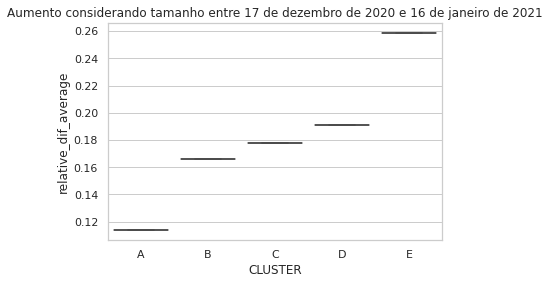

In [95]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias_natal, showfliers = False).set_title("Aumento considerando tamanho entre 17 de dezembro de 2020 e 16 de janeiro de 2021")

**Métricas em ordem decrescente**

In [96]:
mediana_aumento_mortalidade_rel_natal = categorias_natal.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel_natal[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
1,B,0.142857
4,E,0.142857
2,C,0.128713
3,D,0.128008
0,A,0.107368


In [97]:
aumento_considerando_populacao_natal = categorias_natal.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao_natal[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
4,E,0.258725
3,D,0.190997
2,C,0.177507
1,B,0.165877
0,A,0.113635


In [98]:
covid_tur_aumento_categorias_natal.loc[(covid_tur_aumento_categorias_natal['CLUSTER'].eq("B"))].sort_values(by="relative_dif")

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
1152,5221601,40840.0,30.0,30.0,0.0,0.000000,GO,Uruaçu,5221601,215680,375239,B
589,3300258,30593.0,9.0,9.0,0.0,0.000000,RJ,Arraial do Cabo,3300258,260542,4168108,B
451,3115508,21610.0,6.0,6.0,0.0,0.000000,MG,Caxambu,3115508,59100,1958366,B
421,2933208,43716.0,22.0,22.0,0.0,0.000000,BA,Vera Cruz,2933208,139602,126844,B
388,2920700,20617.0,8.0,8.0,0.0,0.000000,BA,Maraú,2920700,25132,1898584,B
...,...,...,...,...,...,...,...,...,...,...,...,...
536,3162500,90497.0,22.0,37.0,15.0,0.681818,MG,São João del Rei,3162500,134743,1444690,B
431,3105608,138204.0,25.0,43.0,18.0,0.720000,MG,Barbacena,3105608,59071,1076344,B
1034,4316808,131365.0,22.0,38.0,16.0,0.727273,RS,Santa Cruz do Sul,4316808,102289,2254033,B
1072,5002209,22190.0,10.0,19.0,9.0,0.900000,MS,Bonito,5002209,256901,5891010,B


In [99]:
covid_tur_aumento_categorias_natal.loc[(covid_tur_aumento_categorias_natal['CLUSTER'].eq("E"))].sort_values(by="relative_dif")

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
262,2607752,26900.0,33.0,33.0,0.0,0.000000,PE,Itapissuma,2607752,0,0,E
306,2705705,21738.0,16.0,16.0,0.0,0.000000,AL,Olho d'Água das Flores,2705705,0,0,E
149,2303956,20274.0,18.0,19.0,1.0,0.055556,CE,Chorozinho,2303956,0,0,E
316,2708303,23996.0,12.0,13.0,1.0,0.083333,AL,São José da Laje,2708303,0,0,E
790,3540754,25130.0,9.0,10.0,1.0,0.111111,SP,Potim,3540754,0,0,E
379,2916500,35883.0,7.0,8.0,1.0,0.142857,BA,Itapicuru,2916500,0,0,E
936,4206306,24382.0,14.0,18.0,4.0,0.285714,SC,Guabiruba,4206306,0,0,E
471,3129806,182153.0,77.0,100.0,23.0,0.298701,MG,Ibirité,3129806,0,0,E
398,2924603,20098.0,12.0,16.0,4.0,0.333333,BA,Pindobaçu,2924603,0,0,E
367,2911808,20700.0,15.0,21.0,6.0,0.400000,BA,Guaratinga,2911808,0,0,E


# **Entre 17 de janeiro de 2021 e 16 de fevereiro de 2021**

In [100]:
covid_tur_aumento_ferias = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2021-01-17', to_date='2021-02-16').to_frame()
covid_tur_aumento_ferias.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento_ferias = covid_tur_aumento_ferias['explodir'].apply(pd.Series)
covid_tur_aumento_ferias.reset_index(inplace=True)
covid_tur_aumento_ferias.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
884,4113304,32139.0,3.0,8.0,5.0,1.666667
508,3146008,33791.0,10.0,26.0,16.0,1.600000
510,3146305,20252.0,4.0,10.0,6.0,1.500000
523,3152006,32035.0,6.0,15.0,9.0,1.500000
20,1301100,38348.0,29.0,72.0,43.0,1.482759
...,...,...,...,...,...,...
178,2311603,29146.0,47.0,46.0,-1.0,-0.021277
645,3306206,37083.0,30.0,29.0,-1.0,-0.033333
163,2306553,42215.0,29.0,28.0,-1.0,-0.034483
210,2414407,33503.0,23.0,22.0,-1.0,-0.043478


In [101]:
covid_tur_aumento_categorias_ferias = pd.merge(covid_tur_aumento_ferias, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias_ferias.sort_values("relative_dif", ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
884,4113304,32139.0,3.0,8.0,5.0,1.666667,PR,Laranjeiras do Sul,4113304,39324,399345,C
508,3146008,33791.0,10.0,26.0,16.0,1.600000,MG,Ouro Fino,3146008,42160,0,C
510,3146305,20252.0,4.0,10.0,6.0,1.500000,MG,Padre Paraíso,3146305,18287,0,D
523,3152006,32035.0,6.0,15.0,9.0,1.500000,MG,Pompéu,3152006,2624,0,D
20,1301100,38348.0,29.0,72.0,43.0,1.482759,AM,Careiro,1301100,20450,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...
178,2311603,29146.0,47.0,46.0,-1.0,-0.021277,CE,Redenção,2311603,39078,0,D
645,3306206,37083.0,30.0,29.0,-1.0,-0.033333,RJ,Vassouras,3306206,35714,1602907,C
163,2306553,42215.0,29.0,28.0,-1.0,-0.034483,CE,Itarema,2306553,45282,55312,C
210,2414407,33503.0,23.0,22.0,-1.0,-0.043478,RN,Touros,2414407,31930,0,C


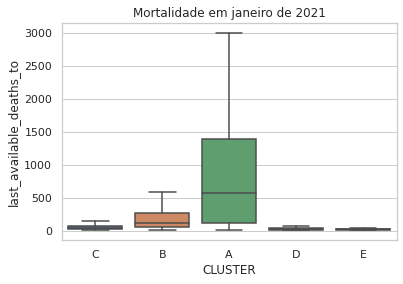

In [102]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias_ferias, showfliers = False).set_title("Mortalidade em janeiro de 2021")

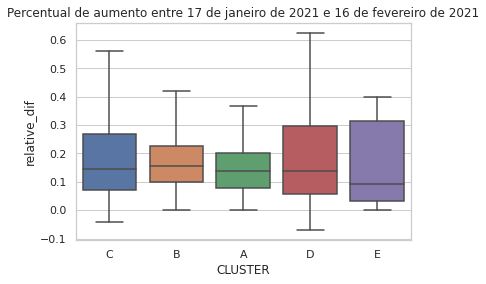

In [103]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias_ferias, showfliers = False).set_title("Percentual de aumento entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

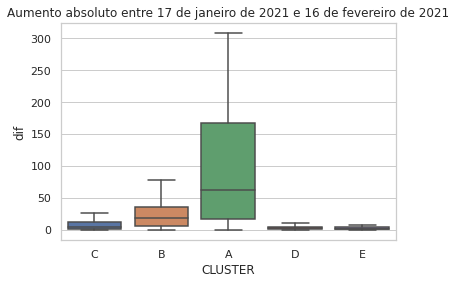

In [104]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias_ferias, showfliers = False).set_title("Aumento absoluto entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

In [105]:
categorias_ferias = pd.concat([covid_tur_aumento_categorias_ferias.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias_ferias.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [106]:
categorias_ferias.reset_index(inplace=True)
categorias_ferias

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,1433.610169,526.0,1637.101695,575.0,203.491525,63.0,0.160324,0.137602,0.140029
1,B,238,183898.054622,123057.0,182.600840,102.0,210.819328,118.0,28.218487,18.0,0.194312,0.156363,0.176176
2,C,397,74728.382872,51338.0,66.869018,36.0,77.365239,46.0,10.496222,5.0,0.208995,0.144444,0.181939
3,D,450,39418.280000,30428.5,29.013333,19.0,33.184444,23.0,4.171111,3.0,0.216091,0.136364,0.189546
4,E,11,39515.181818,24382.0,25.181818,18.0,30.636364,20.0,5.454545,2.0,0.159309,0.090909,0.241147


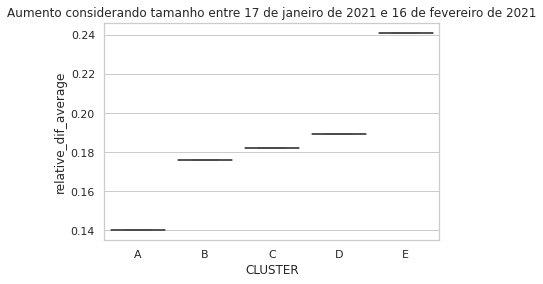

In [107]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias_ferias, showfliers = False).set_title("Aumento considerando tamanho entre 17 de janeiro de 2021 e 16 de fevereiro de 2021")

**Métricas em ordem decrescente**

In [108]:
mediana_aumento_mortalidade_rel_ferias = categorias_ferias.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel_ferias[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
1,B,0.156363
2,C,0.144444
0,A,0.137602
3,D,0.136364
4,E,0.090909


In [109]:
aumento_considerando_populacao_ferias = categorias_ferias.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao_ferias[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
4,E,0.241147
3,D,0.189546
2,C,0.181939
1,B,0.176176
0,A,0.140029


In [110]:
covid_tur_aumento_categorias_ferias.loc[(covid_tur_aumento_categorias_ferias['CLUSTER'].eq("B"))].sort_values(by="relative_dif")

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
388,2920700,20617.0,8.0,8.0,0.0,0.000000,BA,Maraú,2920700,25132,1898584,B
589,3300258,30593.0,9.0,9.0,0.0,0.000000,RJ,Arraial do Cabo,3300258,260542,4168108,B
99,2101400,95929.0,87.0,87.0,0.0,0.000000,MA,Balsas,2101400,151181,680983,B
106,2103000,165525.0,118.0,118.0,0.0,0.000000,MA,Caxias,2103000,191422,0,B
182,2312908,210711.0,324.0,327.0,3.0,0.009259,CE,Sobral,2312908,246103,365839,B
...,...,...,...,...,...,...,...,...,...,...,...,...
431,3105608,138204.0,43.0,78.0,35.0,0.813953,MG,Barbacena,3105608,59071,1076344,B
554,3170701,136602.0,51.0,99.0,48.0,0.941176,MG,Varginha,3170701,46879,1489818,B
744,3525300,151881.0,107.0,214.0,107.0,1.000000,SP,Jaú,3525300,78235,1337804,B
820,3550407,35980.0,14.0,28.0,14.0,1.000000,SP,São Pedro,3550407,17143,1684237,B


In [111]:
covid_tur_aumento_categorias_ferias.loc[(covid_tur_aumento_categorias_ferias['CLUSTER'].eq("E"))].sort_values(by="relative_dif")

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
149,2303956,20274.0,19.0,19.0,0.0,0.000000,CE,Chorozinho,2303956,0,0,E
262,2607752,26900.0,34.0,34.0,0.0,0.000000,PE,Itapissuma,2607752,0,0,E
379,2916500,35883.0,8.0,8.0,0.0,0.000000,BA,Itapicuru,2916500,0,0,E
306,2705705,21738.0,16.0,17.0,1.0,0.062500,AL,Olho d'Água das Flores,2705705,0,0,E
316,2708303,23996.0,13.0,14.0,1.0,0.076923,AL,São José da Laje,2708303,0,0,E
367,2911808,20700.0,22.0,24.0,2.0,0.090909,BA,Guaratinga,2911808,0,0,E
936,4206306,24382.0,18.0,20.0,2.0,0.111111,SC,Guabiruba,4206306,0,0,E
398,2924603,20098.0,16.0,20.0,4.0,0.250000,BA,Pindobaçu,2924603,0,0,E
471,3129806,182153.0,100.0,138.0,38.0,0.380000,MG,Ibirité,3129806,0,0,E
541,3165537,33413.0,21.0,29.0,8.0,0.380952,MG,Sarzedo,3165537,0,0,E


# **Entre 17 de fevereiro de 2021 e 16 de março de 2021**

In [112]:
covid_tur_aumento_carnaval = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2021-02-17', to_date='2021-03-16').to_frame()
covid_tur_aumento_carnaval.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento_carnaval = covid_tur_aumento_carnaval['explodir'].apply(pd.Series)
covid_tur_aumento_carnaval.reset_index(inplace=True)
covid_tur_aumento_carnaval.sort_values(by='relative_dif', ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif
555,3171006,20642.0,10.0,32.0,22.0,2.200000
1014,4311007,26500.0,6.0,17.0,11.0,1.833333
893,4117701,33994.0,10.0,28.0,18.0,1.800000
866,4106506,20580.0,14.0,39.0,25.0,1.785714
372,2914406,25478.0,3.0,8.0,5.0,1.666667
...,...,...,...,...,...,...
74,1507458,24705.0,20.0,20.0,0.0,0.000000
246,2602308,38117.0,28.0,28.0,0.0,0.000000
188,2314102,61410.0,63.0,63.0,0.0,0.000000
440,3109402,28121.0,16.0,15.0,-1.0,-0.062500


In [113]:
covid_tur_aumento_categorias_carnaval = pd.merge(covid_tur_aumento_carnaval, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias_carnaval.sort_values("relative_dif", ascending=False)

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
555,3171006,20642.0,10.0,32.0,22.0,2.200000,MG,Vazante,3171006,36222,0,D
1014,4311007,26500.0,6.0,17.0,11.0,1.833333,RS,Jaguarão,4311007,61472,542891,C
893,4117701,33994.0,10.0,28.0,18.0,1.800000,PR,Palmeira,4117701,4945,197322,D
866,4106506,20580.0,14.0,39.0,25.0,1.785714,PR,Coronel Vivida,4106506,4657,0,D
372,2914406,25478.0,3.0,8.0,5.0,1.666667,BA,Iraquara,2914406,0,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...
74,1507458,24705.0,20.0,20.0,0.0,0.000000,PA,São Geraldo do Araguaia,1507458,16341,0,D
246,2602308,38117.0,28.0,28.0,0.0,0.000000,PE,Bonito,2602308,116617,180997,C
188,2314102,61410.0,63.0,63.0,0.0,0.000000,CE,Viçosa do Ceará,2314102,44198,0,C
440,3109402,28121.0,16.0,15.0,-1.0,-0.062500,MG,Buritizeiro,3109402,0,0,D


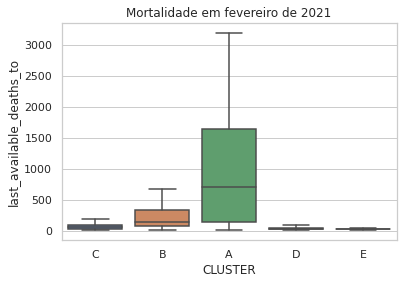

In [114]:
ax = sns.boxplot(x="CLUSTER", y="last_available_deaths_to", data=covid_tur_aumento_categorias_carnaval, showfliers = False).set_title("Mortalidade em fevereiro de 2021")

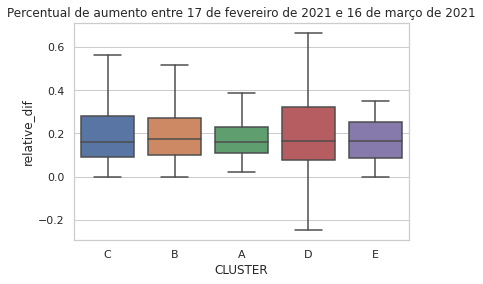

In [115]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif", data=covid_tur_aumento_categorias_carnaval, showfliers = False).set_title("Percentual de aumento entre 17 de fevereiro de 2021 e 16 de março de 2021")

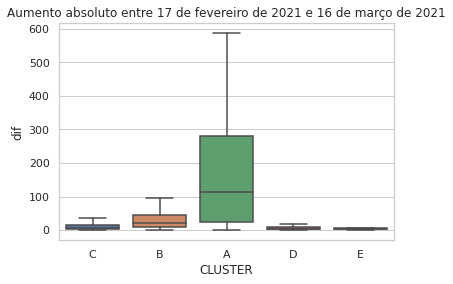

In [116]:
ax = sns.boxplot(x="CLUSTER", y="dif", data=covid_tur_aumento_categorias_carnaval, showfliers = False).set_title("Aumento absoluto entre 17 de fevereiro de 2021 e 16 de março de 2021")

In [117]:
categorias_carnaval = pd.concat([covid_tur_aumento_categorias_carnaval.groupby('CLUSTER').agg(
    n_cities=('city_ibge_code','count'),
    population_mean=('estimated_population','mean'),
    population_median=('estimated_population','median'),
    last_available_deaths_from_mean=('last_available_deaths_from','mean'),
    last_available_deaths_from_median=('last_available_deaths_from','median'),
    last_available_deaths_to_mean=('last_available_deaths_to','mean'),
    last_available_deaths_to_median=('last_available_deaths_to','median'),    
    dif_mean=('dif','mean'),
    dif_median=('dif','median'),
    relative_dif_mean=('relative_dif','mean'),
    relative_dif_median=('relative_dif','median')
),(covid_tur_aumento_categorias_carnaval.groupby('CLUSTER').apply(lambda x: pd.np.average(x.relative_dif, weights=x.estimated_population)).rename('relative_dif_average'))], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  del sys.path[0]


In [118]:
categorias_carnaval.reset_index(inplace=True)
categorias_carnaval

,CLUSTER,n_cities,population_mean,population_median,last_available_deaths_from_mean,last_available_deaths_from_median,last_available_deaths_to_mean,last_available_deaths_to_median,dif_mean,dif_median,relative_dif_mean,relative_dif_median,relative_dif_average
0,A,59,984885.593220,419652.0,1645.033898,580.0,1865.508475,705.0,220.474576,114.0,0.189079,0.159794,0.142200
1,B,238,183898.054622,123057.0,211.857143,118.0,250.113445,143.0,38.256303,22.0,0.226293,0.171786,0.204690
2,C,397,74728.382872,51338.0,77.725441,46.0,91.327456,52.0,13.602015,7.0,0.217472,0.157895,0.195683
3,D,450,39418.280000,30428.5,33.353333,23.0,39.795556,28.0,6.442222,4.0,0.246462,0.166667,0.224332
4,E,11,39515.181818,24382.0,30.636364,20.0,35.454545,24.0,4.818182,4.0,0.202046,0.166667,0.190595


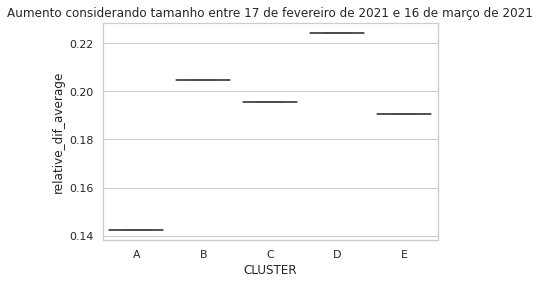

In [119]:
ax = sns.boxplot(x="CLUSTER", y="relative_dif_average", data=categorias_carnaval, showfliers = False).set_title("Aumento considerando tamanho entre 17 de fevereiro de 2021 e 16 de março de 2021")

**Métricas em ordem decrescente**

In [120]:
mediana_aumento_mortalidade_rel_carnaval = categorias_carnaval.sort_values(ascending=False, by="relative_dif_median")
mediana_aumento_mortalidade_rel_carnaval[["CLUSTER","relative_dif_median"]]

,CLUSTER,relative_dif_median
1,B,0.171786
3,D,0.166667
4,E,0.166667
0,A,0.159794
2,C,0.157895


In [121]:
aumento_considerando_populacao_carnaval = categorias_carnaval.sort_values(ascending=False, by="relative_dif_average")
aumento_considerando_populacao_carnaval[["CLUSTER","relative_dif_average"]]

,CLUSTER,relative_dif_average
3,D,0.224332
1,B,0.204690
2,C,0.195683
4,E,0.190595
0,A,0.142200


In [122]:
covid_tur_aumento_categorias_carnaval.loc[(covid_tur_aumento_categorias_carnaval['CLUSTER'].eq("D"))].sort_values(by="relative_dif")

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
103,2102705,22117.0,4.0,3.0,-1.0,-0.250000,MA,Cantanhede,2102705,0,0,D
440,3109402,28121.0,16.0,15.0,-1.0,-0.062500,MG,Buritizeiro,3109402,0,0,D
114,2105104,27269.0,7.0,7.0,0.0,0.000000,MA,Icatu,2105104,7432,0,D
318,2708808,34290.0,21.0,21.0,0.0,0.000000,AL,São Sebastião,2708808,0,0,D
56,1503705,53355.0,37.0,37.0,0.0,0.000000,PA,Itupiranga,1503705,7527,0,D
...,...,...,...,...,...,...,...,...,...,...,...,...
448,3114303,30334.0,16.0,39.0,23.0,1.437500,MG,Carmo do Paranaíba,3114303,18428,0,D
372,2914406,25478.0,3.0,8.0,5.0,1.666667,BA,Iraquara,2914406,0,0,D
866,4106506,20580.0,14.0,39.0,25.0,1.785714,PR,Coronel Vivida,4106506,4657,0,D
893,4117701,33994.0,10.0,28.0,18.0,1.800000,PR,Palmeira,4117701,4945,197322,D


In [123]:
covid_tur_aumento_vazante = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2021-02-05', to_date='2021-03-05').to_frame()
covid_tur_aumento_vazante.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento_vazante = covid_tur_aumento_vazante['explodir'].apply(pd.Series)
covid_tur_aumento_vazante.reset_index(inplace=True)
covid_tur_aumento_vazante.sort_values(by='relative_dif', ascending=False)
covid_tur_aumento_categorias_vazante = pd.merge(covid_tur_aumento_vazante, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias_vazante.loc[(covid_tur_aumento_categorias_vazante['CLUSTER'].eq("D"))].sort_values(by="relative_dif").loc[covid_tur_aumento_categorias_vazante.MUNICIPIO == 'Vazante']

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
555,3171006,20642.0,6.0,25.0,19.0,3.166667,MG,Vazante,3171006,36222,0,D


In [124]:
covid_tur_aumento_cantanhede = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2021-03-05', to_date='2021-04-05').to_frame()
covid_tur_aumento_cantanhede.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento_cantanhede = covid_tur_aumento_cantanhede['explodir'].apply(pd.Series)
covid_tur_aumento_cantanhede.reset_index(inplace=True)
covid_tur_aumento_cantanhede.sort_values(by='relative_dif', ascending=False)
covid_tur_aumento_categorias_cantanhede = pd.merge(covid_tur_aumento_cantanhede, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias_cantanhede.loc[(covid_tur_aumento_categorias_cantanhede['CLUSTER'].eq("D"))].sort_values(by="relative_dif").loc[covid_tur_aumento_categorias_cantanhede.MUNICIPIO == 'Cantanhede']

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
103,2102705,22117.0,4.0,4.0,0.0,0.0,MA,Cantanhede,2102705,0,0,D


In [128]:
covid_tur_aumento_potim = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2021-01-25', to_date='2021-02-25').to_frame()
covid_tur_aumento_potim.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento_potim = covid_tur_aumento_potim['explodir'].apply(pd.Series)
covid_tur_aumento_potim.reset_index(inplace=True)
covid_tur_aumento_potim.sort_values(by='relative_dif', ascending=False)
covid_tur_aumento_categorias_potim = pd.merge(covid_tur_aumento_potim, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias_potim.loc[(covid_tur_aumento_categorias_potim['CLUSTER'].eq("E"))].sort_values(by="relative_dif").loc[covid_tur_aumento_categorias_potim.MUNICIPIO == 'Potim']

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
790,3540754,25130.0,10.0,16.0,6.0,0.6,SP,Potim,3540754,0,0,E


In [127]:
covid_tur_aumento_chorozinho = covid_tur.groupby(['city_ibge_code', 'estimated_population']).apply(calcula_aumento_relativo, x_col='last_available_deaths', date_col='date', from_date='2021-03-07', to_date='2021-04-07').to_frame()
covid_tur_aumento_chorozinho.rename(columns={0: "explodir"}, inplace=True)
covid_tur_aumento_chorozinho = covid_tur_aumento_chorozinho['explodir'].apply(pd.Series)
covid_tur_aumento_chorozinho.reset_index(inplace=True)
covid_tur_aumento_chorozinho.sort_values(by='relative_dif', ascending=False)
covid_tur_aumento_categorias_chorozinho = pd.merge(covid_tur_aumento_chorozinho, cidades_turisticas, left_on="city_ibge_code", right_on="COD_IBGE", how="left")
covid_tur_aumento_categorias_chorozinho.loc[(covid_tur_aumento_categorias_chorozinho['CLUSTER'].eq("E"))].sort_values(by="relative_dif").loc[covid_tur_aumento_categorias_chorozinho.MUNICIPIO == 'Chorozinho']

,city_ibge_code,estimated_population,last_available_deaths_from,last_available_deaths_to,dif,relative_dif,UF,MUNICIPIO,COD_IBGE,QUANTIDADE_VISITAS_ESTIMADAS_ NACIONAL,ARRECADACAO,CLUSTER
149,2303956,20274.0,19.0,22.0,3.0,0.157895,CE,Chorozinho,2303956,0,0,E
